# notebook exploring how to make light

In [16]:
%matplotlib inline

In [17]:
import numpy as np
import time
import pyglet
import matplotlib.pyplot as plt
from numba import njit

from src.game import discrete_space
from src.game import creatures

In [18]:
window_dims = (800, 600)
cell_size = 10

# ==== Pyglet Setup ====
window = pyglet.window.Window(*window_dims)
batch1 = pyglet.graphics.Batch()
group1 = pyglet.graphics.Group()
clock1 = pyglet.clock.get_default()

# ==== Grid ====
grid = discrete_space.Grid(cell_size, window_dims, batch1, group1, 'default_map.png')
grid.make_floor(rand_col='bw')

# ==== Agents ====
grid.add_agent(creatures.LightBoi(grid, clock1, batch1, group1))
grid.agents_to_l1()


loaded: default_map.png


# Lights with Numba

In [39]:
class LightSource:
    def __init__(self, grid, xy, batch, group):
        self.batch = batch
        self.group = group
        self.grid_ref = grid
        self.xy = np.array(xy)
        self.center = self.xy + [0.5, 0.5]

        # --- x_range ---
        self.dims = self.grid_ref.dims
        self.x_range = np.linspace(0, self.dims[0]-1, self.dims[0])
        self.x_range = self.x_range.astype(int)

        # --- radial setup ---
        self.light_density = 360
        self.radial = np.linspace(0, 2*np.pi, self.light_density)

    @staticmethod
    @njit(nogil=True, parallel=True)
    def ray_array(radial, dims, ray_steps=1000):
        rays = np.zeros((len(radial), 2, ray_steps))

        x_steps = np.sin(radial)*dims[0]
        y_steps = np.cos(radial)*dims[1]

        for ii in range(len(radial)):
            x_coords = np.linspace(0, x_steps[ii], ray_steps)
            y_coords = np.linspace(0, y_steps[ii], ray_steps)
            rays[ii][0] = x_coords
            rays[ii][1] = y_coords

        return rays

    @staticmethod
    @njit(nogil=True)
    def check_collision(xy, rays, grid):
        light_grid = np.zeros_like(grid)
        for ray in rays:
            for ii in range(len(ray)):
                x = int(ray[0][ii] + xy[0])
                y = int(ray[1][ii] + xy[1])
                if grid[y, x] == 0:
                    light_grid[y, x] = 1
                else:
                    break
        return light_grid


In [40]:
lightboi = LightSource(grid, [10, 10], batch1, group1)

dims = lightboi.dims
radial = lightboi.radial
x_range = lightboi.x_range
l0 = lightboi.grid_ref.layers[0]
xy = lightboi.xy

In [41]:
rays = lightboi.ray_array(radial, dims)

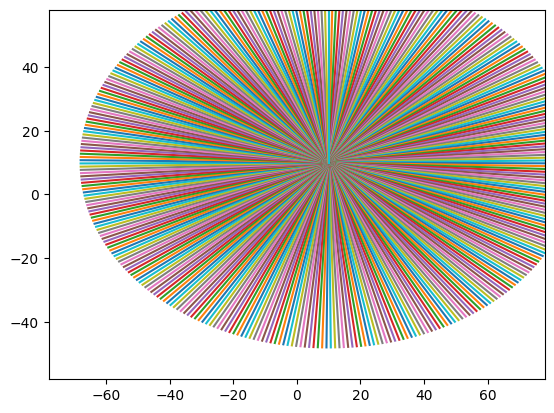

: 

In [45]:
fig, ax = plt.subplots()  #figsize=(12, 6))

for ray in rays:
    ax.plot(ray[0], ray[1])
xlm = dims[0]
ylm = dims[1]
ax.set(xlim=(-xlm, xlm), ylim=(-ylm, ylm))
plt.show()

In [42]:
light_grid = lightboi.check_collision(xy, rays, l0)